# Notebook 7: Feature Distributions

## Purpose
Understand the distribution and characteristics of each feature in the PathWild dataset.

## Key Questions
- Which features are normally distributed vs heavily skewed?
- Do any features need transformation?
- Which features show strongest separation between presence/absence?
- Are there unexpected bimodal distributions?

## Key Observations to Look For
- **Normal vs Skewed**: Identify features needing transformation
- **Seasonal Patterns**: NDVI should peak in summer, snow in winter
- **Presence/Absence Separation**: Features with clear separation are good predictors
- **Statistical Significance**: p-values and effect sizes for discrimination

In [6]:
# Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro, ttest_ind
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Determine project root and output directories
possible_roots = [
    Path('.'),  # If running from project root
    Path('..'),  # If running from notebooks directory
    Path('../..'),  # If running from subdirectory
]

data_root = None
for root in possible_roots:
    if (root / 'data' / 'features').exists():
        data_root = root / 'data'
        break

if data_root is None:
    data_root = Path('../data')

# Create output directories relative to project root
figures_dir = data_root / 'figures'
reports_dir = data_root / 'reports'
figures_dir.mkdir(parents=True, exist_ok=True)
reports_dir.mkdir(parents=True, exist_ok=True)

print(f'✓ Setup complete')
print(f'  Output directory: {data_root.absolute()}')

✓ Setup complete
  Output directory: /Users/jongalentine/Projects/pathwild/notebooks/../data


## 1. Load Data and Detect Columns

This section loads the feature dataset and identifies key columns for analysis. The notebook dynamically detects timestamp, presence/absence, and feature columns to work with different dataset configurations.

### What to Look For
- Confirm all expected columns are present
- Verify numeric vs categorical column detection is correct
- Note the total number of features for subsequent analysis

In [7]:
# Load data
from pathlib import Path

# Try multiple possible paths
possible_paths = [
    Path('data/features/complete_context.csv'),  # From project root
    Path('../data/features/complete_context.csv'),  # From notebooks directory
    Path('../../data/features/complete_context.csv'),  # From subdirectory
]

data_path = None
for path in possible_paths:
    if path.exists():
        data_path = path
        break

if data_path is None:
    raise FileNotFoundError(
        f'Data file not found. Tried: {[str(p) for p in possible_paths]}\n'
        f'Please run: python scripts/combine_feature_files.py\n'
        f'Or ensure you are running the notebook from the project root directory.'
    )

print(f'Loading data from: {data_path}')
df = pd.read_csv(data_path)

# Detect temporal columns (year, month, day_of_year_cos/sin - no timestamp in this dataset)
year_col = 'year' if 'year' in df.columns else None
month_col = 'month' if 'month' in df.columns else None
has_day_of_year = 'day_of_year_cos' in df.columns and 'day_of_year_sin' in df.columns

# Look for presence/target
presence_col = None
for col in df.columns:
    if col.lower() in ['presence', 'target', 'label', 'is_presence', 'elk_present']:
        presence_col = col
        break

print(f'Dataset shape: {df.shape}')
print(f'Year column: {year_col}')
print(f'Month column: {month_col}')
print(f'Day of year encoding: {has_day_of_year}')
print(f'Presence column: {presence_col}')

# Identify numeric and categorical columns
# Exclude index and temporal metadata columns from feature analysis
exclude_cols = ['point_index', 'year']
numeric_cols = [col for col in df.select_dtypes(include=[np.number]).columns.tolist() 
                if col not in exclude_cols]
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

print(f'\nNumeric columns: {len(numeric_cols)}')
print(f'Categorical columns: {len(categorical_cols)}')

Loading data from: ../data/features/complete_context.csv
Dataset shape: (431862, 32)
Year column: year
Month column: month
Day of year encoding: True
Presence column: elk_present

Numeric columns: 29
Categorical columns: 1


## 2. Univariate Distributions

Understanding individual feature distributions is essential for:
1. **Feature engineering**: Identifying features that may need transformation
2. **Model selection**: Some algorithms assume normal distributions
3. **Outlier detection**: Spotting unusual values
4. **Data quality**: Verifying features have expected variation

### What This Code Does
- Creates histograms with kernel density estimation (KDE) for all numeric features
- Overlays mean (red) and median (blue) reference lines
- Displays summary statistics (mean, std) in each subplot title

### Interpreting Histograms

**Distribution Shapes:**
- **Normal (bell-shaped)**: Ideal for many ML algorithms; mean ≈ median
- **Right-skewed (long tail right)**: Mean > median; consider log transform
- **Left-skewed (long tail left)**: Mean < median; consider square or exponential transform
- **Bimodal (two peaks)**: May indicate mixture of populations (e.g., winter vs summer)
- **Uniform (flat)**: Low predictive power; all values equally likely

**KDE Overlay:**
- Smooth curve showing estimated probability density
- Peaks indicate most common values
- Multiple peaks suggest multimodal distribution

### What to Look For
- **Heavily skewed features**: May need transformation for linear models
- **Bimodal distributions**: Investigate if modes correspond to presence/absence or seasons
- **Constant features**: Single spike indicates no variation (placeholder values)
- **Extreme outliers**: Long tails extending far from center

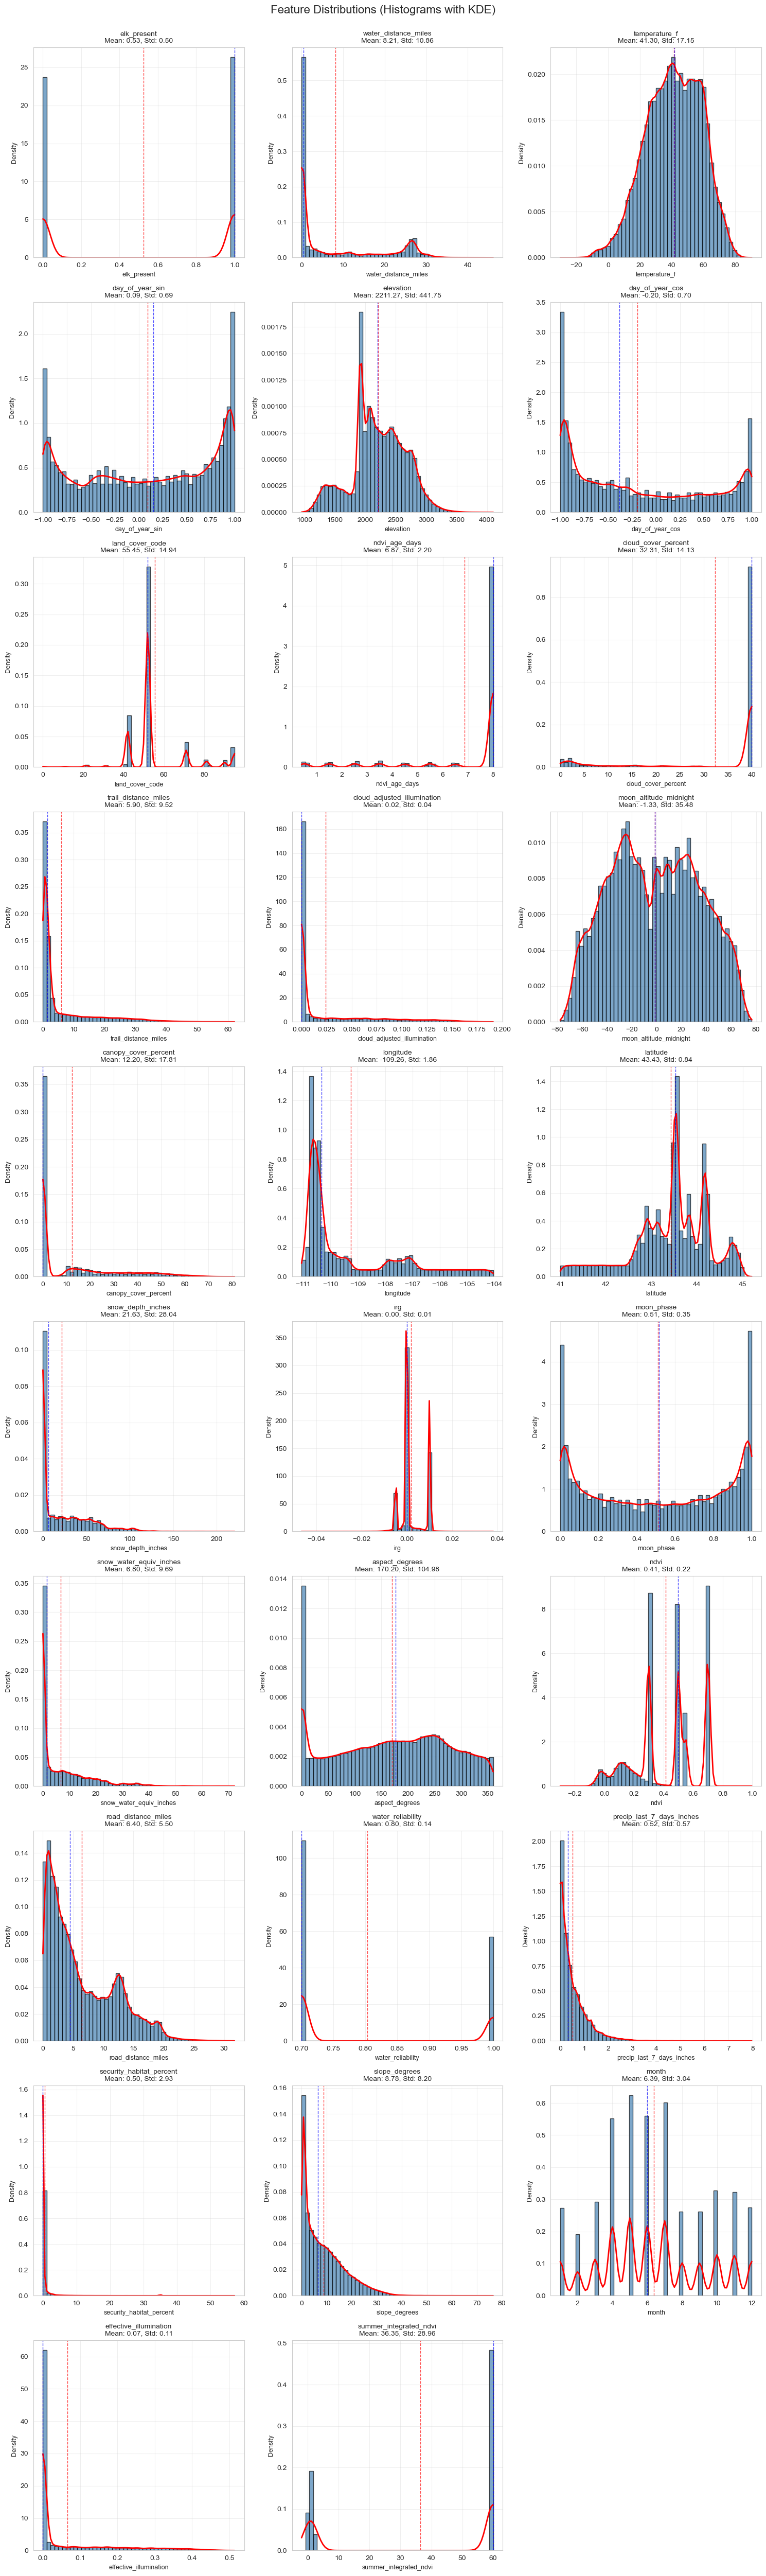

✓ Saved feature distributions


In [8]:
# Create histograms for all numeric features
n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

for idx, col in enumerate(numeric_cols):
    ax = axes[idx]
    data = df[col].dropna()
    
    if len(data) > 0:
        # Histogram with KDE
        ax.hist(data, bins=50, alpha=0.7, color='steelblue', edgecolor='black', density=True)
        
        # KDE overlay
        try:
            from scipy.stats import gaussian_kde
            kde = gaussian_kde(data)
            x_range = np.linspace(data.min(), data.max(), 100)
            ax.plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')
        except:
            pass
        
        # Add statistics
        mean_val = data.mean()
        median_val = data.median()
        std_val = data.std()
        
        ax.axvline(mean_val, color='red', linestyle='--', linewidth=1, alpha=0.7)
        ax.axvline(median_val, color='blue', linestyle='--', linewidth=1, alpha=0.7)
        
        ax.set_title(f'{col}\nMean: {mean_val:.2f}, Std: {std_val:.2f}', fontsize=10)
        ax.set_xlabel(col, fontsize=9)
        ax.set_ylabel('Density', fontsize=9)
        ax.grid(alpha=0.3)

# Hide extra subplots
for idx in range(len(numeric_cols), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Feature Distributions (Histograms with KDE)', fontsize=16, y=1.00)
plt.tight_layout()
plt.savefig(figures_dir / 'feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print('✓ Saved feature distributions')

In [9]:
# Identify skewed features
skewness_data = []

for col in numeric_cols:
    data = df[col].dropna()
    if len(data) > 0:
        skew = data.skew()
        skewness_data.append({'feature': col, 'skewness': skew})

skewness_df = pd.DataFrame(skewness_data).sort_values('skewness', key=abs, ascending=False)

print('\nFeature skewness (sorted by absolute value):')
print(skewness_df)

highly_skewed = skewness_df[abs(skewness_df['skewness']) > 1]
print(f'\n⚠ {len(highly_skewed)} features with |skewness| > 1 (may need transformation):')
for _, row in highly_skewed.iterrows():
    print(f"  - {row['feature']}: {row['skewness']:.2f}")


Feature skewness (sorted by absolute value):
                        feature   skewness
24     security_habitat_percent  10.101923
9          trail_distance_miles   2.129331
23    precip_last_7_days_inches   2.113585
7                 ndvi_age_days  -1.772245
27       effective_illumination   1.717584
10  cloud_adjusted_illumination   1.704775
18      snow_water_equiv_inches   1.701387
8           cloud_cover_percent  -1.425879
12         canopy_cover_percent   1.301603
15            snow_depth_inches   1.275824
13                    longitude   1.202207
6               land_cover_code   1.183825
25                slope_degrees   1.153035
1          water_distance_miles   0.917378
21          road_distance_miles   0.893004
14                     latitude  -0.704328
22            water_reliability   0.666665
16                          irg   0.588452
5               day_of_year_cos   0.431721
28       summer_integrated_ndvi  -0.407987
20                         ndvi  -0.271227
2       

## 3. Categorical Features

Categorical features require different visualization and analysis than numeric features. This section examines the distribution of categories for land cover type, snow data source, and other non-numeric variables.

### What This Code Does
- Displays value counts for each categorical feature
- Creates bar charts showing category frequencies
- Identifies rare categories that may cause issues in train/test splits

### What to Look For
- **Dominant categories**: One category >80% of observations may indicate imbalance
- **Rare categories**: Categories with <1% observations may not appear in test set
- **Expected categories**: Verify land cover types match Wyoming ecosystems
- **Missing/Unknown**: High counts of "unknown" or "other" may indicate data quality issues

### Elk Ecology Context for Land Cover
Expected dominant categories in Wyoming elk habitat:
- **Shrub**: Sagebrush-steppe dominates lower elevations
- **Grassland**: Mountain meadows and prairie edges
- **Evergreen forest**: Lodgepole pine, spruce-fir at higher elevations
- **Deciduous forest**: Aspen stands (important for elk)
- **Wetland**: Riparian areas (high elk use)

Land covers like "developed" or "barren" should be rare in elk habitat data.


land_cover_type:
land_cover_type
shrub               266825
evergreen_forest     68923
grassland            33037
emergent_wetland     26326
pasture              10208
unknown              10048
wetland               9136
deciduous_forest      3740
outside_bounds        3584
mixed_forest            35
Name: count, dtype: int64


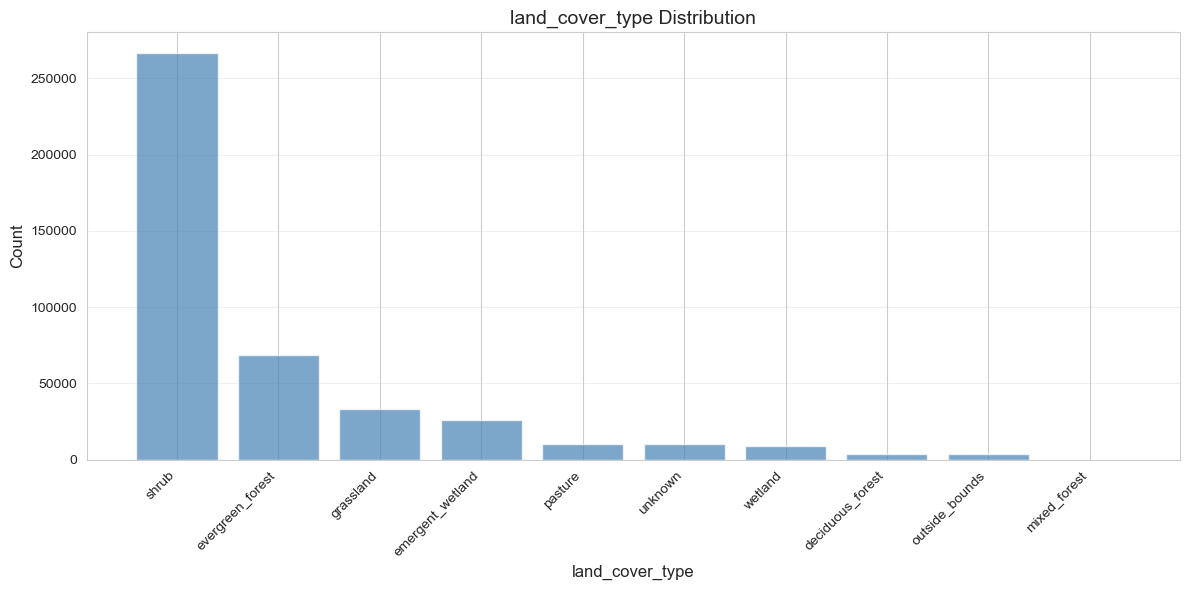

In [10]:
# Analyze categorical features
# Note: This dataset uses year/month columns, not timestamp
if len(categorical_cols) > 0:
    for col in categorical_cols:
        # Skip metadata columns that aren't features
        if col not in ['point_index']:  # Skip index columns
            print(f'\n{col}:')
            print(df[col].value_counts())
            
            # Create count plot
            plt.figure(figsize=(12, 6))
            value_counts = df[col].value_counts()
            plt.bar(range(len(value_counts)), value_counts.values, color='steelblue', alpha=0.7)
            plt.xlabel(col, fontsize=12)
            plt.ylabel('Count', fontsize=12)
            plt.title(f'{col} Distribution', fontsize=14)
            plt.xticks(range(len(value_counts)), value_counts.index, rotation=45, ha='right')
            plt.grid(axis='y', alpha=0.3)
            plt.tight_layout()
            plt.savefig(figures_dir / f'{col}_distribution.png', dpi=300, bbox_inches='tight')
            plt.show()
else:
    print('No categorical features found')

## 4. Seasonal Patterns

Many environmental features vary predictably across seasons. Understanding these patterns helps validate data quality and informs feature engineering decisions.

### What This Code Does
- Calculates monthly mean for each feature
- Plots line charts showing seasonal variation
- Highlights features with strong vs weak seasonal signals

### Expected Seasonal Patterns

| Feature | Expected Pattern |
|---------|-----------------|
| NDVI | Peak Jun-Aug, lowest Dec-Feb |
| Temperature | Peak Jul-Aug, lowest Dec-Jan |
| Snow depth | Peak Mar-Apr, zero Jun-Sep |
| Elevation (of observations) | Higher in summer, lower in winter (migration) |
| Precipitation | Variable, often bimodal (spring, fall) |

### What to Look For
- **Features matching expectations**: Validates data quality
- **Flat lines**: No seasonal variation may indicate placeholder values
- **Inverted patterns**: May indicate unit errors or reversed encoding
- **Unexpected peaks**: Investigate data collection artifacts

### Elk Ecology Context
Seasonal patterns in features directly reflect elk biology:
- **Spring green-up (NDVI increase)**: Triggers migration to summer range
- **Deep snow**: Forces elk to lower elevations and concentrates them
- **Summer heat**: Elk seek shade and water
- **Fall rut**: Behavioral changes affect movement patterns

If environmental features don't show seasonal patterns, the model cannot learn seasonal habitat selection.

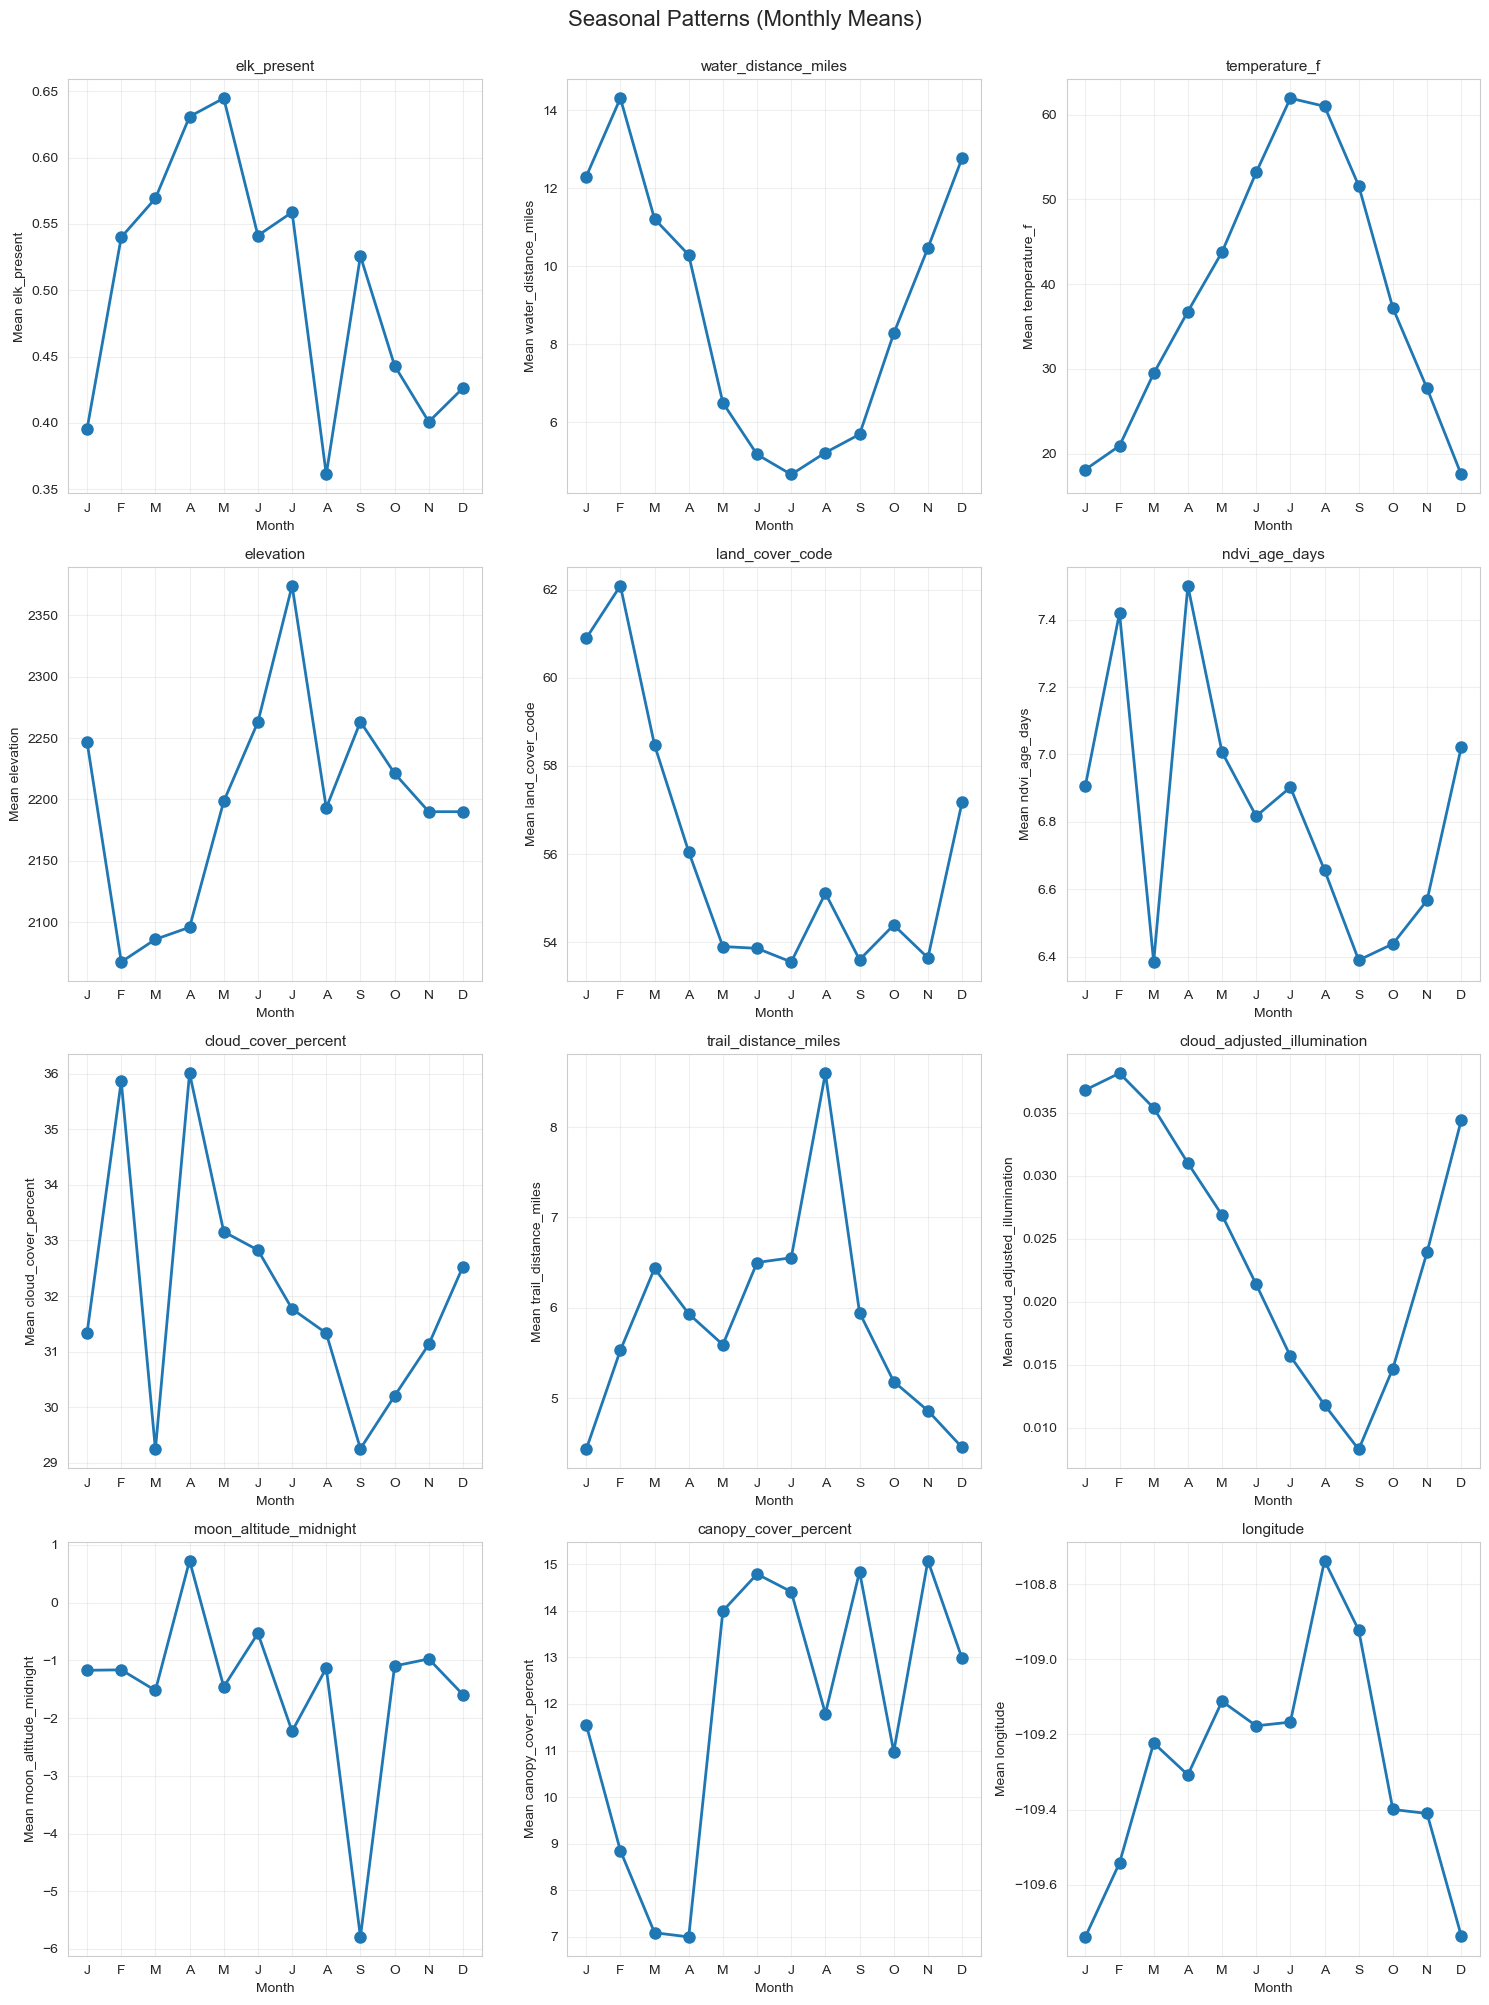

✓ Saved seasonal patterns


In [11]:
# Analyze seasonal patterns
if month_col:
    # Select key features for seasonal analysis (exclude temporal columns themselves)
    seasonal_features = [col for col in numeric_cols 
                        if col not in ['month', 'year', 'day_of_year_cos', 'day_of_year_sin']][:12]
    
    n_cols = 3
    n_rows = (len(seasonal_features) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for idx, col in enumerate(seasonal_features):
        ax = axes[idx]
        monthly_mean = df.groupby(month_col)[col].mean()
        
        ax.plot(monthly_mean.index, monthly_mean.values, marker='o', linewidth=2, markersize=8)
        ax.set_xlabel('Month', fontsize=10)
        ax.set_ylabel(f'Mean {col}', fontsize=10)
        ax.set_title(col, fontsize=11)
        ax.set_xticks(range(1, 13))
        ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
        ax.grid(alpha=0.3)
    
    # Hide extra subplots
    for idx in range(len(seasonal_features), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Seasonal Patterns (Monthly Means)', fontsize=16, y=1.00)
    plt.tight_layout()
    plt.savefig(figures_dir / 'seasonal_patterns.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print('✓ Saved seasonal patterns')
else:
    print('Cannot analyze seasonal patterns without month column')

## 5. Presence vs Absence Distributions

The core question for habitat modeling: do features differ between presence and absence locations? Features with clear separation between classes are more likely to be predictive.

### What This Code Does
- Creates overlapping histograms comparing presence (blue) vs absence (red) distributions
- Adds vertical lines showing class means
- Calculates mean difference between classes

### Interpreting the Plots

**Histogram Overlap:**
- **Complete overlap**: Feature provides no discrimination - similar for presence/absence
- **Partial overlap**: Feature has some predictive power
- **Little overlap**: Feature strongly discriminates - high predictive value
- **Reversed expectations**: May indicate data issues or counterintuitive ecology

**Mean Lines:**
- **Large separation**: Means are far apart - strong effect size
- **Small separation**: Means are similar - weak effect
- **Direction matters**: Which class has higher values is ecologically meaningful

### What to Look For
- **Features with clear separation**: Best candidates for modeling
- **Direction of differences**: Do elk prefer higher or lower values?
- **Shape differences**: Even if means are similar, distribution shapes may differ
- **Outlier-driven differences**: Check if separation is due to a few extreme values

### Elk Ecology Context
Expected directions of difference (presence vs absence):
- **NDVI**: Presence > Absence (elk prefer greener areas)
- **Slope**: Presence < Absence (elk avoid steep terrain for foraging)
- **Road distance**: Presence > Absence (elk avoid roads)
- **Water distance**: Presence < Absence (elk stay near water)
- **Security habitat**: Presence > Absence (elk prefer cover nearby)

Unexpected directions warrant investigation - either data issues or genuinely surprising ecology.

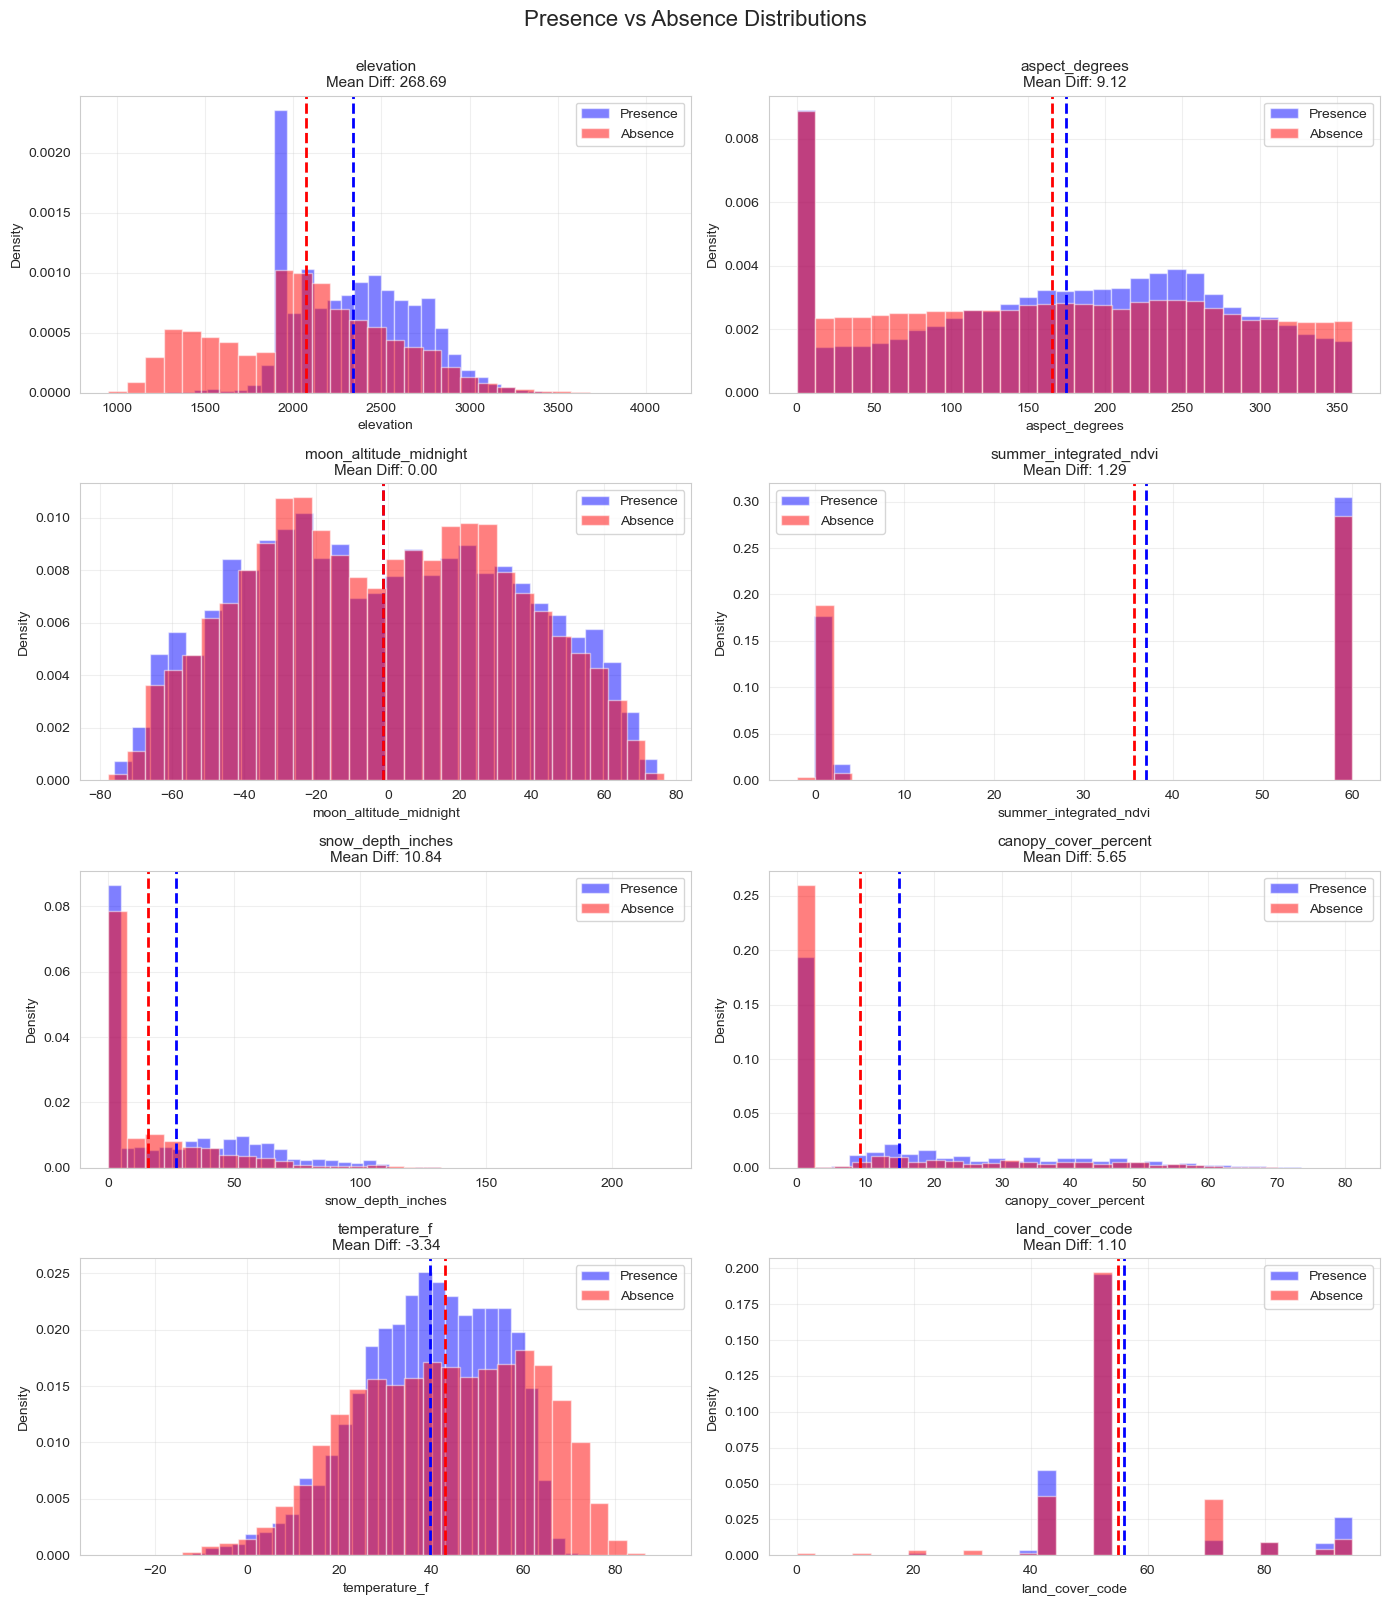

✓ Saved presence vs absence distributions


In [12]:
# Compare distributions for presence vs absence
if presence_col:
    # Select top features by variance for visualization
    feature_variance = df[numeric_cols].var().sort_values(ascending=False)
    top_features = feature_variance.head(8).index.tolist()
    
    fig, axes = plt.subplots(4, 2, figsize=(14, 16))
    axes = axes.flatten()
    
    for idx, col in enumerate(top_features):
        ax = axes[idx]
        
        presence_data = df[df[presence_col] == 1][col].dropna()
        absence_data = df[df[presence_col] == 0][col].dropna()
        
        # Overlapping histograms
        ax.hist(presence_data, bins=30, alpha=0.5, color='blue', label='Presence', density=True)
        ax.hist(absence_data, bins=30, alpha=0.5, color='red', label='Absence', density=True)
        
        # Add means
        ax.axvline(presence_data.mean(), color='blue', linestyle='--', linewidth=2)
        ax.axvline(absence_data.mean(), color='red', linestyle='--', linewidth=2)
        
        # Calculate mean difference
        mean_diff = presence_data.mean() - absence_data.mean()
        
        ax.set_xlabel(col, fontsize=10)
        ax.set_ylabel('Density', fontsize=10)
        ax.set_title(f'{col}\nMean Diff: {mean_diff:.2f}', fontsize=11)
        ax.legend()
        ax.grid(alpha=0.3)
    
    plt.suptitle('Presence vs Absence Distributions', fontsize=16, y=1.00)
    plt.tight_layout()
    plt.savefig(figures_dir / 'presence_absence_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print('✓ Saved presence vs absence distributions')
else:
    print('Cannot compare presence/absence without target column')

## 6. Statistical Tests

Statistical tests quantify whether observed differences between presence and absence are meaningful or could be due to random chance. This section performs t-tests and calculates effect sizes.

### What This Code Does
- Performs independent t-tests comparing presence vs absence for each feature
- Calculates Cohen's d effect size (standardized mean difference)
- Ranks features by statistical significance and effect size

### Interpreting Results

**P-values:**
- **p < 0.01**: Strong evidence of difference (highly significant)
- **p < 0.05**: Moderate evidence (significant)
- **p > 0.05**: Insufficient evidence (not significant at conventional threshold)
- **Note**: With large samples, even tiny differences can be "significant" - effect size matters more!

**Cohen's d (Effect Size):**
- **|d| < 0.2**: Negligible effect - not practically meaningful
- **|d| 0.2-0.5**: Small effect - detectable but modest
- **|d| 0.5-0.8**: Medium effect - meaningful difference
- **|d| > 0.8**: Large effect - strong discrimination

### What to Look For
- **Features with p < 0.01 AND |d| > 0.5**: Best predictors - statistically and practically significant
- **High p-value, any d**: Not reliable predictors
- **Low p-value, small d**: Statistically significant but not meaningful (common with large N)
- **Sign of d**: Positive = presence has higher values; Negative = absence has higher values

### Caution with Large Samples
With 400,000+ observations, virtually any difference will be "statistically significant." Focus on effect size (Cohen's d) rather than p-values for practical importance. A feature with p < 0.001 but d = 0.05 is less useful than one with p = 0.01 and d = 0.6.

In [13]:
# Perform t-tests for presence vs absence
if presence_col:
    test_results = []
    
    for col in numeric_cols:
        presence_data = df[df[presence_col] == 1][col].dropna()
        absence_data = df[df[presence_col] == 0][col].dropna()
        
        if len(presence_data) > 0 and len(absence_data) > 0:
            # T-test
            t_stat, p_value = ttest_ind(presence_data, absence_data)
            
            # Cohen's d (effect size)
            mean_diff = presence_data.mean() - absence_data.mean()
            pooled_std = np.sqrt((presence_data.std()**2 + absence_data.std()**2) / 2)
            cohens_d = mean_diff / pooled_std if pooled_std > 0 else 0
            
            test_results.append({
                'feature': col,
                'p_value': p_value,
                'cohens_d': cohens_d,
                'presence_mean': presence_data.mean(),
                'absence_mean': absence_data.mean(),
                'mean_diff': mean_diff
            })
    
    results_df = pd.DataFrame(test_results).sort_values('p_value')
    
    print('\nStatistical test results (sorted by p-value):')
    print(results_df)
    
    # Save results
    results_df.to_csv(reports_dir / 'feature_discrimination.csv', index=False)
    print('\n✓ Saved feature discrimination results')
    
    # Flag highly discriminative features
    significant = results_df[(results_df['p_value'] < 0.01) & (abs(results_df['cohens_d']) > 0.5)]
    print(f'\n✓ {len(significant)} features with p<0.01 and |Cohen\'s d|>0.5:')
    for _, row in significant.iterrows():
        print(f"  - {row['feature']}: p={row['p_value']:.2e}, d={row['cohens_d']:.2f}")
else:
    print('Cannot perform statistical tests without target column')


Statistical test results (sorted by p-value):
                        feature        p_value  cohens_d  presence_mean  \
0                   elk_present   0.000000e+00  0.000000       1.000000   
26                        month   0.000000e+00 -0.175514       6.133244   
25                slope_degrees   0.000000e+00  0.212239       9.601641   
22            water_reliability   0.000000e+00  0.491512       0.834603   
20                         ndvi   0.000000e+00  0.175101       0.432395   
18      snow_water_equiv_inches   0.000000e+00  0.419748       8.669714   
16                          irg   0.000000e+00  0.250376       0.002493   
15            snow_depth_inches   0.000000e+00  0.396268      26.764113   
13                    longitude   0.000000e+00 -1.024428    -110.074717   
12         canopy_cover_percent   0.000000e+00  0.322249      14.874302   
14                     latitude   0.000000e+00  0.504195      43.625349   
9          trail_distance_miles   0.000000e+00 -1.047

## 7. Normality Tests

Some statistical methods and machine learning algorithms assume features are normally distributed. This section tests normality and visualizes departures using Q-Q plots.

### What This Code Does
- Creates Q-Q (Quantile-Quantile) plots for highly skewed features
- Performs Shapiro-Wilk normality tests (where sample size permits)
- Identifies features that may benefit from transformation

### Interpreting Q-Q Plots
Q-Q plots compare the observed distribution against a theoretical normal distribution:
- **Points on diagonal line**: Feature is approximately normal
- **S-shaped curve**: Heavy tails (more extreme values than normal)
- **Upward curve at ends**: Right-skewed distribution
- **Downward curve at ends**: Left-skewed distribution
- **Staircase pattern**: Discrete values or limited precision

### When Normality Matters
- **Linear regression**: Residuals should be normal (not necessarily features)
- **T-tests**: Assume normal distributions (robust with large samples)
- **Tree-based models (Random Forest, XGBoost)**: Do NOT require normality
- **Neural networks**: Generally robust to non-normality

### What to Look For
- **Features far from diagonal**: Strong candidates for transformation
- **Log-transform candidates**: Right-skewed features (distances, counts)
- **Square-root candidates**: Moderately skewed features
- **Leave as-is**: Features close to normal, or when using tree-based models

### Practical Recommendations
- For elk habitat modeling with tree-based algorithms (recommended), normality is not critical
- Transform features primarily for interpretability and visualization
- If using linear models, transform skewed features with log1p() or Box-Cox

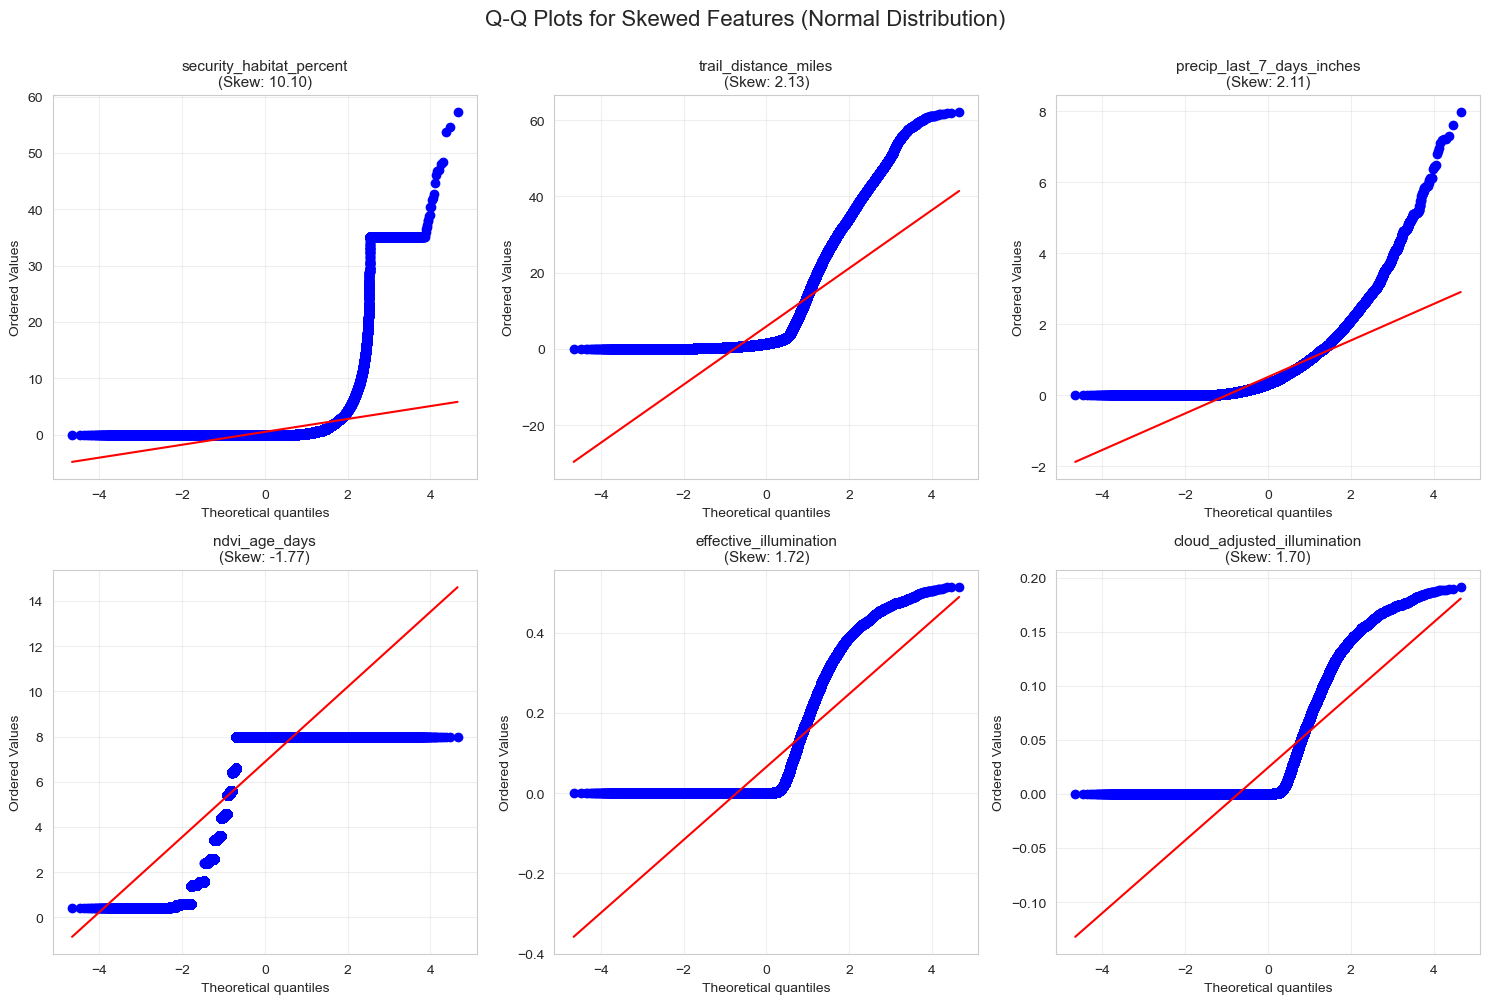

✓ Saved Q-Q plots for skewed features


In [14]:
# Create Q-Q plots for features with strong skew
from scipy.stats import probplot

highly_skewed_features = skewness_df[abs(skewness_df['skewness']) > 1]['feature'].head(6).tolist()

if len(highly_skewed_features) > 0:
    n_cols = 3
    n_rows = (len(highly_skewed_features) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for idx, col in enumerate(highly_skewed_features):
        ax = axes[idx]
        data = df[col].dropna()
        
        if len(data) > 0:
            probplot(data, dist="norm", plot=ax)
            ax.set_title(f'{col}\n(Skew: {data.skew():.2f})', fontsize=11)
            ax.grid(alpha=0.3)
    
    # Hide extra subplots
    for idx in range(len(highly_skewed_features), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Q-Q Plots for Skewed Features (Normal Distribution)', fontsize=16, y=1.00)
    plt.tight_layout()
    plt.savefig(figures_dir / 'normality_qqplots.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print('✓ Saved Q-Q plots for skewed features')
else:
    print('No highly skewed features found for Q-Q plots')


In [15]:
# Test normality for each feature
normality_results = []

for col in numeric_cols[:20]:  # Limit to first 20 for performance
    data = df[col].dropna()
    if len(data) > 3 and len(data) < 5000:  # Shapiro-Wilk works best with smaller samples
        stat, p_value = shapiro(data)
        normality_results.append({
            'feature': col,
            'shapiro_stat': stat,
            'p_value': p_value,
            'is_normal': p_value > 0.05
        })

if len(normality_results) > 0:
    normality_df = pd.DataFrame(normality_results).sort_values('p_value', ascending=False)
    
    print('\nNormality test results:')
    print(normality_df)
    
    non_normal = normality_df[normality_df['p_value'] < 0.05]
    print(f'\n⚠ {len(non_normal)} features fail normality test (p<0.05)')
    print('These may benefit from transformation (log, sqrt, box-cox)')

## 8. Feature Summary Table

This section compiles all distribution statistics into a comprehensive summary table for easy reference during feature selection and model development.

### What This Code Does
- Aggregates statistics: missing %, range, mean, std, skewness, kurtosis
- Includes normality test results where available
- Includes discrimination metrics (p-value, Cohen's d) where available
- Saves to CSV for use in downstream analysis

### How to Use the Summary Table

**Feature Selection Prioritization:**
1. **High Cohen's d + Low missing %**: Top-tier features
2. **Moderate Cohen's d + Low skewness**: Good features, ready to use
3. **High missing %**: Consider imputation or exclusion
4. **High skewness**: Consider transformation if using linear models

**Saved Output:**
The summary table is saved to `data/reports/feature_summary.csv` for:
- Documentation of feature characteristics
- Reference during model development
- Comparison before/after data pipeline updates

### Next Steps After This Notebook
1. Review `feature_discrimination.csv` to identify best predictors
2. Consider transformations for highly skewed features
3. Proceed to Notebook 08 for spatial-temporal pattern analysis
4. Use findings to inform feature engineering and selection

In [16]:
# Create comprehensive feature summary
summary_data = []

for col in numeric_cols:
    data = df[col].dropna()
    
    if len(data) > 0:
        summary = {
            'feature': col,
            'dtype': df[col].dtype,
            'missing_pct': (df[col].isnull().sum() / len(df) * 100),
            'min': data.min(),
            'max': data.max(),
            'mean': data.mean(),
            'std': data.std(),
            'skewness': data.skew(),
            'kurtosis': data.kurtosis()
        }
        
        # Add normality test if available
        norm_result = [r for r in normality_results if r['feature'] == col]
        if norm_result:
            summary['normality_p'] = norm_result[0]['p_value']
        
        # Add discrimination metrics if available
        if presence_col:
            disc_result = results_df[results_df['feature'] == col]
            if len(disc_result) > 0:
                summary['discrimination_p'] = disc_result.iloc[0]['p_value']
                summary['cohens_d'] = disc_result.iloc[0]['cohens_d']
        
        summary_data.append(summary)

summary_df = pd.DataFrame(summary_data)

print('\nFeature summary:')
print(summary_df)

# Save summary
summary_df.to_csv(reports_dir / 'feature_summary.csv', index=False)
print(f'\n✓ Saved feature summary to {reports_dir / "feature_summary.csv"}')


Feature summary:
                        feature    dtype  missing_pct         min  \
0                   elk_present    int64     0.000000    0.000000   
1          water_distance_miles  float64     0.000000    0.000000   
2                 temperature_f  float64     0.000000  -30.181004   
3               day_of_year_sin  float64     0.000000   -0.999999   
4                     elevation  float64     0.829895  948.544556   
5               day_of_year_cos  float64     0.000000   -0.999979   
6               land_cover_code  float64     0.829895    0.000000   
7                 ndvi_age_days  float64     0.000000    0.406974   
8           cloud_cover_percent  float64     0.000000    0.000000   
9          trail_distance_miles  float64     0.000000    0.000017   
10  cloud_adjusted_illumination  float64     0.000000    0.000000   
11       moon_altitude_midnight  float64     0.000000  -77.677050   
12         canopy_cover_percent  float64     0.829895    0.000000   
13              

## Summary

This notebook analyzed feature distributions:

1. **Univariate Distributions**: Identified normal vs skewed features
2. **Categorical Features**: Analyzed category distributions
3. **Seasonal Patterns**: Examined temporal variation
4. **Presence/Absence**: Compared distributions between classes
5. **Statistical Tests**: Identified discriminative features
6. **Normality Tests**: Flagged features needing transformation

**Key Findings**:
- Review `data/reports/feature_discrimination.csv` for predictive features
- Review `data/reports/feature_summary.csv` for comprehensive statistics
- Features with high |Cohen's d| are strong predictors

**Next Steps**:
- Proceed to Notebook 08 for spatial-temporal analysis